In [4]:
!pip install bayesian-optimization

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df= pd.read_csv("/content/drive/MyDrive/Research Papers/XAI/Data/Dataset_Without_Lagged_Variables.csv")

In [15]:
df

,STATE,YEAR,real GDP(in billion U.S. dollars),ENROLL,TOTAL_EXPENDITURE,PER_CAPITA_EXPENDITURE,INSTRUCTION_EXPENDITURE_RATIO,SUPPORT_SERVICES_EXPENDITURE_RATIO,CAPITAL_OUTLAY_EXPENDITURE_RATIO
0,Alabama,2000,157.22,730184,5003267,6.852063,0.510009,0.263638,0.132694
1,Alabama,2001,156.85,728532,5086045,6.981224,0.522291,0.270203,0.106229
2,Alabama,2002,160.42,726367,5147821,7.087080,0.528522,0.274795,0.096380
3,Alabama,2003,165.13,727900,5298932,7.279753,0.531638,0.287126,0.081579
4,Alabama,2004,176.63,730418,5450269,7.461849,0.527606,0.290014,0.082495
...,...,...,...,...,...,...,...,...,...
845,Wyoming,2012,38.86,89994,1670728,18.564882,0.506247,0.323518,0.127636
846,Wyoming,2013,38.85,91533,1675477,18.304622,0.505451,0.326129,0.127677
847,Wyoming,2014,39.56,92732,1775999,19.151954,0.487575,0.312929,0.162149
848,Wyoming,2015,40.42,93867,1942406,20.693172,0.461237,0.291128,0.210782


In [17]:
# Prepare features and target variable
X = df[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
          "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
          "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y = df["real GDP(in billion U.S. dollars)"]

In [18]:
# Group by STATE and split within each state by YEAR
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [21]:
cutoff_year = 2014  # Set the cutoff year for splitting
for state in df["STATE"].unique(): # Replace 'data' with 'df'
    state_data = df[df["STATE"] == state] # Replace 'data' with 'df'
    train_data = pd.concat([train_data, state_data[state_data["YEAR"] < cutoff_year]])
    test_data = pd.concat([test_data, state_data[state_data["YEAR"] >= cutoff_year]])

In [22]:

# Define features (X) and target (y) for training and testing
X_train = train_data[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
                      "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
                      "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y_train = train_data["real GDP(in billion U.S. dollars)"]

X_test = test_data[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
                    "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
                    "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y_test = test_data["real GDP(in billion U.S. dollars)"]

In [23]:
# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [25]:

# Evaluate model performance
metrics = {
    "R2 Score": r2_score(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
}

In [26]:
# Display metrics
print("Model Evaluation Metrics:")
print("R2 Score:", metrics["R2 Score"])
print("MAE:", metrics["MAE"])
print("RMSE:", metrics["RMSE"])


Model Evaluation Metrics:
R2 Score: 0.9295677237623963
MAE: 49.29063133333328
RMSE: 112.52967097616902


<font color= "Green"> <h2> Baysian Optimization

In [27]:
# Import required libraries
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import numpy as np

In [28]:
# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300]),
    'max_depth': hp.choice('max_depth', [5, 10, 15, 20, None]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])
}

In [29]:
# Define the objective function for Bayesian Optimization
def objective(params):
    model = RandomForestRegressor(random_state=42, **params)
    neg_mse = -np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error'))
    return {'loss': neg_mse, 'status': STATUS_OK}

In [30]:
# Initialize trials object
trials = Trials()


In [33]:
# Run Bayesian Optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of optimization iterations
    trials=trials,
    rstate=np.random.default_rng(42)
)


100%|██████████| 50/50 [01:03<00:00,  1.27s/trial, best loss: 17869.66306300226]


In [35]:
# Train the Random Forest model with optimized hyperparameters
optimized_model = RandomForestRegressor(
    random_state=42,
    n_estimators=[50, 100, 200, 300][best_params['n_estimators']],
    max_depth=[5, 10, 15, 20, None][best_params['max_depth']],
    min_samples_split=[2, 5, 10][best_params['min_samples_split']],
    min_samples_leaf=[1, 2, 4][best_params['min_samples_leaf']]
)
optimized_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=50,
                      random_state=42)

In [36]:
# Predict on the test set
y_pred_optimized = optimized_model.predict(X_test)

In [37]:
# Evaluate optimized model performance
optimized_metrics = {
    "R2 Score": r2_score(y_test, y_pred_optimized),
    "MAE": mean_absolute_error(y_test, y_pred_optimized),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_optimized))
}

In [38]:
# Display optimized model metrics
print("Optimized Model Evaluation Metrics:")
print("R2 Score:", optimized_metrics["R2 Score"])
print("MAE:", optimized_metrics["MAE"])
print("RMSE:", optimized_metrics["RMSE"])

Optimized Model Evaluation Metrics:
R2 Score: 0.921764136742044
MAE: 51.09583634822016
RMSE: 118.59984636035381


<font color= "Green"> <h1> <b> SHAP

In [39]:
# Import SHAP and other libraries
import shap
import matplotlib.pyplot as plt

In [40]:
# Train the base Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [41]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

In [42]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

In [43]:
# 1. Force Plot (for a single prediction)
shap.initjs()  # Load JavaScript visualization
single_prediction = 0  # Index of the sample to explain
shap.force_plot(explainer.expected_value, shap_values[single_prediction, :], X_test.iloc[single_prediction, :])

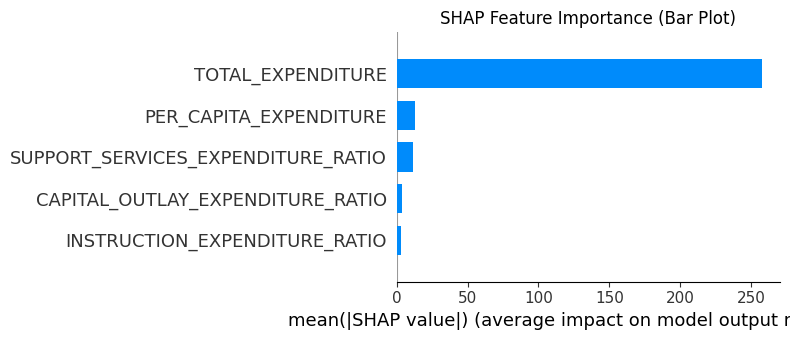

In [44]:
# 2. Feature Importance (Global)
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test, plot_type="bar")


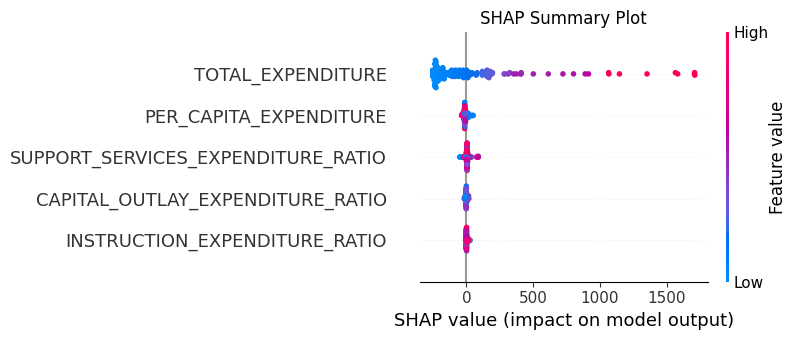

In [45]:
# 3. Summary Plot
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test)